In [150]:
NOTEBOOK_NAME = "e023_seed_ave"

In [151]:
import numpy as np
import polars as pl
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import seaborn as sns
import japanize_matplotlib

In [152]:
train = pl.read_csv("../data/train.csv")
test = pl.read_csv("../data/test.csv")
era = pl.read_csv("../data/era_improve.csv")
sample_submission = pl.read_csv("../data/sample_submission.csv")

# 前処理

In [153]:
train = train.join(era, on="時代", how="left")
test = test.join(era, on="時代", how="left")

# データ型の変更

In [154]:
categorical_cols = [
    "棟名",
    "種別2",
    "国",
    "都道府県 ※美工品は「所有者住所（所在都道府県）」",
    "時代",
    "保管施設の名称",
    "所有者名",
    "管理団体又は責任者",
    "所在地",
]

In [155]:
# カウントエンコーディングを行う
merge_df = pl.concat([train[categorical_cols], test[categorical_cols]])

merge_count_df = merge_df.select(
    [pl.count().over(col).alias(f"{col}_count") for col in categorical_cols]
)

train_count_df = merge_count_df.slice(0, train.shape[0])
test_count_df = merge_count_df.slice(train.shape[0])

train = pl.concat([train, train_count_df], how="horizontal")
test = pl.concat([test, test_count_df], how="horizontal")

In [156]:
# Trainにしかないデータを削除する
def only_train_is_null(train: pl.DataFrame, test: pl.DataFrame, col: str):
    only_train = set(train.get_column(col).unique())
    only_test = set(test.get_column(col).unique())

    share_value = only_train & only_test

    return train.with_columns(
        pl.when(pl.col(col).is_in(list(share_value)))
        .then(pl.col(col))
        .otherwise(None)
        .alias(col)
    )


for col in categorical_cols:
    train = only_train_is_null(train, test, col)

In [157]:
for col in categorical_cols:
    train = train.with_columns(pl.col(col).cast(pl.Categorical).alias(col))
    test = test.with_columns(pl.col(col).cast(pl.Categorical).alias(col))

# Fold

In [158]:
FOLD_NUM = 5

In [159]:
empty = np.zeros(train.height)
fold = StratifiedKFold(n_splits=FOLD_NUM, shuffle=True, random_state=33)

for idx, (_, val_idx) in enumerate(fold.split(train, train.get_column("is_kokuhou"))):
    empty[val_idx] = idx

train = train.with_columns(pl.Series(empty).cast(pl.Int64).alias("fold"))

# LightGBM

In [160]:
use_col = []

base_col = ["緯度", "経度", "開始", "終了"]

use_col += base_col
use_col += categorical_cols
use_col += [f"{col}_count" for col in categorical_cols]

len(use_col)

22

In [161]:
use_col

['緯度',
 '経度',
 '開始',
 '終了',
 '棟名',
 '種別2',
 '国',
 '都道府県 ※美工品は「所有者住所（所在都道府県）」',
 '時代',
 '保管施設の名称',
 '所有者名',
 '管理団体又は責任者',
 '所在地',
 '棟名_count',
 '種別2_count',
 '国_count',
 '都道府県 ※美工品は「所有者住所（所在都道府県）」_count',
 '時代_count',
 '保管施設の名称_count',
 '所有者名_count',
 '管理団体又は責任者_count',
 '所在地_count']

In [162]:
def get_lgbm_prediction(
    train: pl.DataFrame, use_col: list, params: dict, FOLD_NUM: int = 5
) -> tuple[np.ndarray, list]:
    print(params)
    # 学習データ全体に対する推論結果を保存するobjectを作成
    oof = np.zeros((len(train)))

    # テストデータに対する推論、特徴量重要度(後述)を計算するために、モデルを保存するobjectを作成
    models = []

    # Cross Validationによる学習の実施
    for fold in range(FOLD_NUM):
        print(f"Start fold {fold}")

        # polarsをpandasに変換
        train_pd = train.to_pandas()

        # foldごとにtrainとvalidに分ける
        train_fold = train_pd[train_pd["fold"] != fold]
        valid_fold = train_pd[train_pd["fold"] == fold]

        # X(説明変数)とy(目的変数)に分ける
        X_train = train_fold.drop("is_kokuhou", axis=1)
        X_valid = valid_fold.drop("is_kokuhou", axis=1)
        y_train = train_fold[["is_kokuhou"]]
        y_valid = valid_fold[["is_kokuhou"]]

        # 利用する説明変数に限定する
        X_train = X_train[use_col]
        X_valid = X_valid[use_col]

        # LightGBMが認識可能な形にデータセットを変換
        lgb_train = lgb.Dataset(X_train, y_train)
        lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)

        # モデルの学習
        model = lgb.train(
            params,
            lgb_train,
            num_boost_round=10000,  # 学習のiteration回数
            valid_sets=[lgb_train, lgb_eval],
            callbacks=[
                lgb.early_stopping(stopping_rounds=100)
            ],  # Early stopingの回数、binary_loglossが改善しないiterationが100回続いたら学習を止める
        )

        # モデルを保存
        models.append(model)

        # validデータに対する推論
        y_valid_pred = model.predict(X_valid, num_iteration=model.best_iteration)

        # validデータに対する推論の性能を計算
        calc_f1_score = roc_auc_score(y_valid, y_valid_pred)
        print(f"fold {fold} Score: {calc_f1_score}")

        # oofに推論結果を保存
        valid_idx = X_valid.index
        oof[valid_idx] = y_valid_pred
    return oof, models

In [163]:
# LightGBMで用いるパラメーターを指定
# ref: https://lightgbm.readthedocs.io/en/v3.3.5/Parameters.html
# params = {"objective": "binary", "metric": "auc", "verbosity": -1, "seed": 42}

In [164]:
from sklearn.metrics import f1_score

seed_ave_models = []
oofs = []
oof_scores = []
for seed in [42]:
    params = {
        "boosting_type": "gbdt",
        "objective": "binary",
        "metric": "auc",
        # "num_leaves": 31,
        # "learning_rate": 0.01,
        "feature_fraction": 0.9,  # ->これを加えるとseedの変更が有効になる
        # "bagging_fraction": 0.8,
        # "bagging_freq": 5,
        "verbose": -1,
        "seed": seed,
    }
    # params = {"objective": "binary", "metric": "auc", "verbosity": -1, "seed": seed}
    # ↑の状態でseedだけ変えても、結果が変わらなかった
    oof, models = get_lgbm_prediction(train, use_col, params)
    oof_score = roc_auc_score(y_true=train.get_column("is_kokuhou"), y_score=oof)

    seed_ave_models.extend(models)
    oofs.append(oof)
    oof_scores.append(oof_score)

# 0.01 から 0.99 まで 0.01 刻みで閾値を変えて、F1 score を計算する
max_f1_score = 0

oof_score_mean = np.mean(oof_scores)
oof_mean = np.vstack(oofs).mean(axis=0)

for thr in np.arange(0.01, 1, 0.01):
    calc_f1_score = f1_score(
        train.get_column("is_kokuhou"), (oof_mean > thr).astype(int)
    )
    print(f"thr: {thr}, f1_score: {calc_f1_score}")
    if max_f1_score < calc_f1_score:
        max_f1_score = calc_f1_score
        best_thr = thr
print("AUC: ", oof_score_mean)
print(f"Optimized thr: {best_thr}, f1 score: {max_f1_score}")

{'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'feature_fraction': 0.9, 'verbose': -1, 'seed': 42}
Start fold 0
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[27]	training's auc: 0.95039	valid_1's auc: 0.840773
fold 0 Score: 0.8407729468599034
Start fold 1
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[69]	training's auc: 0.980097	valid_1's auc: 0.802432
fold 1 Score: 0.8024315619967795
Start fold 2
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[73]	training's auc: 0.980602	valid_1's auc: 0.837327
fold 2 Score: 0.8373268921095008
Start fold 3
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[23]	training's auc: 0.947358	valid_1's auc: 0.811783
fold 3 Score: 0.8117834138486311
Start fold 4
Training until validation scores don't improve for 100 rounds
Early stopping, best

In [165]:
oofs

[array([0.0030705 , 0.21608731, 0.30389018, ..., 0.03861086, 0.21218213,
        0.01417061])]

In [166]:
oof_score_mean = np.mean(oof_scores)
oof_mean = np.vstack(oofs).mean(axis=0)

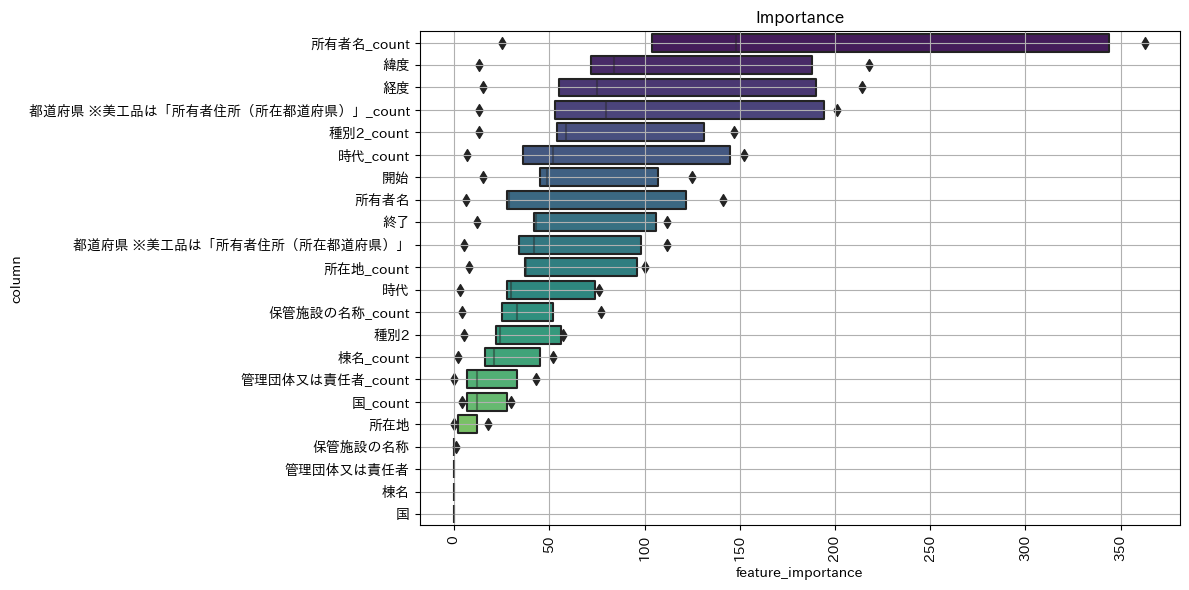

In [167]:
def visualize_importance(models: list, use_col: list) -> None:
    """lightGBM の model 配列の feature importance を plot する
    CVごとのブレを boxen plot として表現します.

    args:
        models:
            List of lightGBM models
        feat_train_df:
            学習時に使った DataFrame
    """
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df["feature_importance"] = model.feature_importance()
        _df["column"] = use_col
        _df["fold"] = i + 1
        feature_importance_df = pd.concat(
            [feature_importance_df, _df], axis=0, ignore_index=True
        )

    order = (
        feature_importance_df.groupby("column")
        .sum()[["feature_importance"]]
        .sort_values("feature_importance", ascending=False)
        .index[:50]
    )

    fig, ax = plt.subplots(figsize=(12, max(6, len(order) * 0.25)))
    sns.boxenplot(
        data=feature_importance_df,
        x="feature_importance",
        y="column",
        order=order,
        ax=ax,
        palette="viridis",
        orient="h",
    )
    ax.tick_params(axis="x", rotation=90)
    ax.set_title("Importance")
    ax.grid()
    fig.tight_layout()
    return fig, ax


fig, ax = visualize_importance(seed_ave_models, use_col)

In [168]:
# k 個のモデルの予測を作成. shape = (5, N_test,).
pred = np.array(
    [model.predict(test.select(use_col).to_pandas()) for model in seed_ave_models]
)

# k 個のモデルの予測値の平均 shape = (N_test,).
pred = np.mean(pred, axis=0)  # axis=0 なので shape の `k` が潰れる

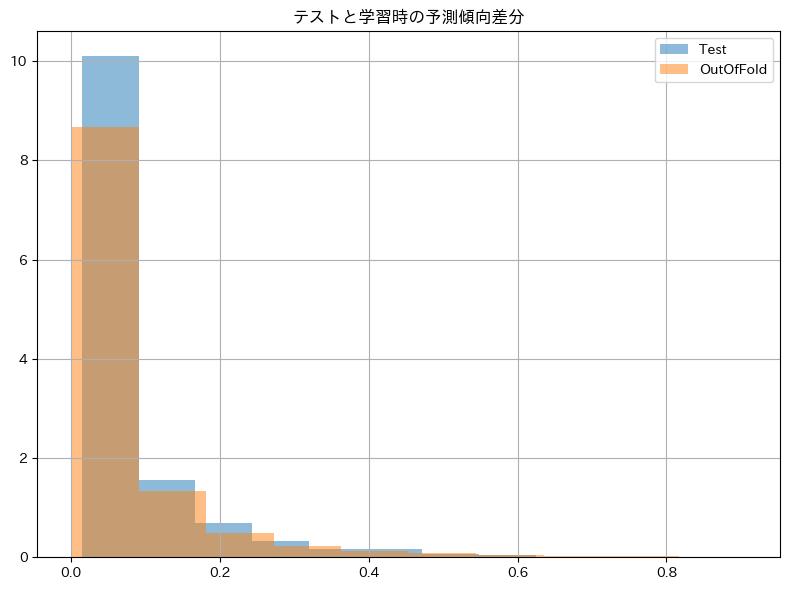

In [169]:
fig, ax = plt.subplots(figsize=(8, 6))

vmax = 0.02
# bins = np.linspace(0, 1, 0.1)
ax.hist(pred, density=True, alpha=0.5, label="Test")
ax.hist(oof, density=True, alpha=0.5, label="OutOfFold")
ax.grid()
ax.legend()
ax.set_title("テストと学習時の予測傾向差分")

fig.tight_layout()

In [170]:
train.with_columns(pl.Series(oof).cast(pl.Float64).alias("oof")).write_csv(
    f"../oof/oof_{NOTEBOOK_NAME}_f1score_{max_f1_score:.4f}_auc_{oof_score:.4f}.csv"
)

In [171]:
sample_submission.with_columns(pl.Series("is_kokuhou", pred > best_thr).cast(int))

is_kokuhou
i64
0
1
1
0
0
1
0
0
0


In [172]:
sample_submission = sample_submission.with_columns(
    pl.Series("is_kokuhou", pred > best_thr).cast(int)
)
sample_submission

is_kokuhou
i64
0
1
1
0
0
1
0
0
0


In [173]:
sample_submission.write_csv(
    f"../sub/{NOTEBOOK_NAME}_f1score_{max_f1_score:.4f}_auc_{oof_score:.4f}.csv"
)
f"../sub/{NOTEBOOK_NAME}_f1score_{max_f1_score:.4f}_auc_{oof_score:.4f}.csv"

'../sub/e023_seed_ave_f1score_0.3443_auc_0.8014.csv'